https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

In [2]:
# titanic = sns.load_dataset('titanic')
# titanic
# X = train.drop(["Survived", "Name", "Ticket", "Cabin"], axis = 1)
# y = train.Survived
# X.head()

In [36]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

from sklearn.datasets import load_breast_cancer
import pandas as pd
breast_cancer = load_breast_cancer()

# Данные

In [ ]:
breast_cancer_df = pd.DataFrame(data = breast_cancer.data, columns = breast_cancer.feature_names)
breast_cancer_df['is_benign'] = breast_cancer.target
breast_cancer_df

- 212 - Malignant (0) (Доброкачественные)
- 357 - Benign (1) (Злокачественные)


In [19]:
breast_cancer_df['is_benign'].value_counts()

1    357
0    212
Name: is_benign, dtype: int64

# Случайный лес как средство борьбы с переобучением

## Обычное дерево

In [37]:
roc_aucs = {'train': [], 'test': [], 'cross_val_scores': []}
for depth in range(1, 50):
    # Инициализируем (сажаем) дерево решений
    clf_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth)
    clf_forest = RandomForestClassifier(max_depth=depth)

    # Обучаем дерево решений
    clf_tree.fit(X_train, y_train)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv = 5).mean()
    roc_aucs['train'].append(roc_auc_score(y_true=y_train, y_score=clf_tree.predict_proba(X_train)[:, 1]))
    roc_aucs['test'].append(roc_auc_score(y_true=y_test, y_score=clf_tree.predict_proba(X_test)[:, 1]))
    roc_aucs['cross_val_scores'].append(mean_cross_val_score)

<AxesSubplot:>

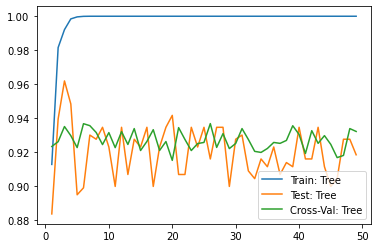

In [39]:
import seaborn as sns

sns.lineplot(y=roc_aucs['train'], x=np.arange(1,50,1), label = 'Train: Tree')
sns.lineplot(y=roc_aucs['test'], x=np.arange(1,50,1), label = 'Test: Tree')
sns.lineplot(y=roc_aucs['cross_val_scores'], x=np.arange(1,50,1), label = 'Cross-Val: Tree')

In [6]:
X = breast_cancer_df.drop(['is_benign'], axis = 1)
y = breast_cancer_df['is_benign']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# GridSearchCV

In [7]:
# 1. Инициализация 
clf_rf = RandomForestClassifier()

# 2. Выбор параметров для GridSearchCV
parameters = {'n_estimators': [10, 20, 30, 40, 50], # количество деревьев
             'max_depth': [2, 5, 7, 10]}   # максимальная глубина каждого дерева

# Инициализируем стэк классификаторов с параметрами из сетки parameters. 
grid_search_cv_clf = GridSearchCV(clf_rf, parameters, cv=5, scoring = 'roc_auc')

# 3. Обучение кучи моделей в GridSearchCV
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 10, 'n_estimators': 20}

In [8]:
# Можно сразу получить лучшую модель
best_clf = grid_search_cv_clf.best_estimator_

In [9]:
result = pd.DataFrame(grid_search_cv_clf.cv_results_)[['param_max_depth', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
result['mean_test_score'] = round(result['mean_test_score']*100, 2)
result['std_test_score'] = round(result['std_test_score']*100, 2)
result[:10]

,param_max_depth,param_max_depth,mean_test_score,std_test_score,rank_test_score
16,10,10,99.00,1.28,1
12,7,7,98.99,1.23,2
13,7,7,98.95,1.37,3
9,5,5,98.91,1.38,4
5,5,5,98.90,1.67,5
19,10,10,98.88,1.52,6
14,7,7,98.87,1.83,7
3,2,2,98.87,1.26,8
6,5,5,98.85,1.74,9
7,5,5,98.81,1.76,10


In [10]:
# Замеряем итоговое качество на трейне и тесте
round(roc_auc_score(y_score = best_clf.predict_proba(X_test)[:, 1], y_true=y_test)*100, 2)

98.66

# GradientBoosting

In [16]:
# 1. Инициализация 
clf_rf = GradientBoostingClassifier()

# 2. Выбор параметров для GridSearchCV
parameters = {'n_estimators': [10, 20, 30, 40], # количество деревьев
             'max_depth': [2, 5, 7, 10, 12]}   # максимальная глубина каждого дерева

# Инициализируем стэк классификаторов с параметрами из сетки parameters. 
grid_search_cv_clf = GridSearchCV(clf_rf, parameters, cv=5, scoring = 'roc_auc')

# 3. Обучение кучи моделей в GridSearchCV
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 2, 'n_estimators': 40}

In [17]:
# Можно сразу получить лучшую модель
best_clf = grid_search_cv_clf.best_estimator_

In [18]:
# Замеряем итоговое качество на трейне и тесте
round(roc_auc_score(y_score = best_clf.predict_proba(X_test)[:, 1], y_true=y_test)*100, 2)

98.07